### Preamble

In [1]:
import numpy as np
from torch.utils.data import DataLoader
from fmnist import testset
from tqdm import tqdm
from style import bold, plot_accuracies, plot_figure_3a, print_preds_memory
from style import print_table_1, print_table_2, print_table_3
from metrics import compute_accuracies, compute_disagreement
from metrics import compute_ensemble_predictions, compute_abstention_rate

### Random Sources

- Sources of randomness are:

    - **RS**: Random state for initialization
    - **LOO**: Leave-one-out in the training data  
<br/>

- For RS, we do not currently set or track the specific random seed used

- For LOO, removed inputs are chosen randomly, and the random state for initialization has seed 0

- We have modified LOO for these experiments to leave out 10% of the training data (60k -> 54k inputs)

In [2]:
random_sources = ['rs', 'loo']

### Load data and model predictions

##### FMNIST test data (normalized [0,1])

In [3]:
test = DataLoader(testset, batch_size=len(testset), shuffle=False)
test = next(iter(test))
X_test, y_test = test[0].numpy(), test[1].numpy()
n_inputs = X_test.shape[0]

##### Predictions from 200 models trained with main.py

In [4]:
n_models = 200
preds = []
for i, random_source in enumerate(random_sources):
    print(bold(f'\nSource of Randomness: {random_source.upper()}'))
    preds.append(np.load(f'{random_source}_preds_fmnist_{n_models}.npy'))
    print_preds_memory(preds[i])


Source of Randomness: RS
200 models, 10000 test inputs
40KB memory (single model predictions)
8MB memory (all model predictions)


Source of Randomness: LOO
200 models, 10000 test inputs
40KB memory (single model predictions)
8MB memory (all model predictions)



### Table 1: Singleton model accuracy (FMNIST)

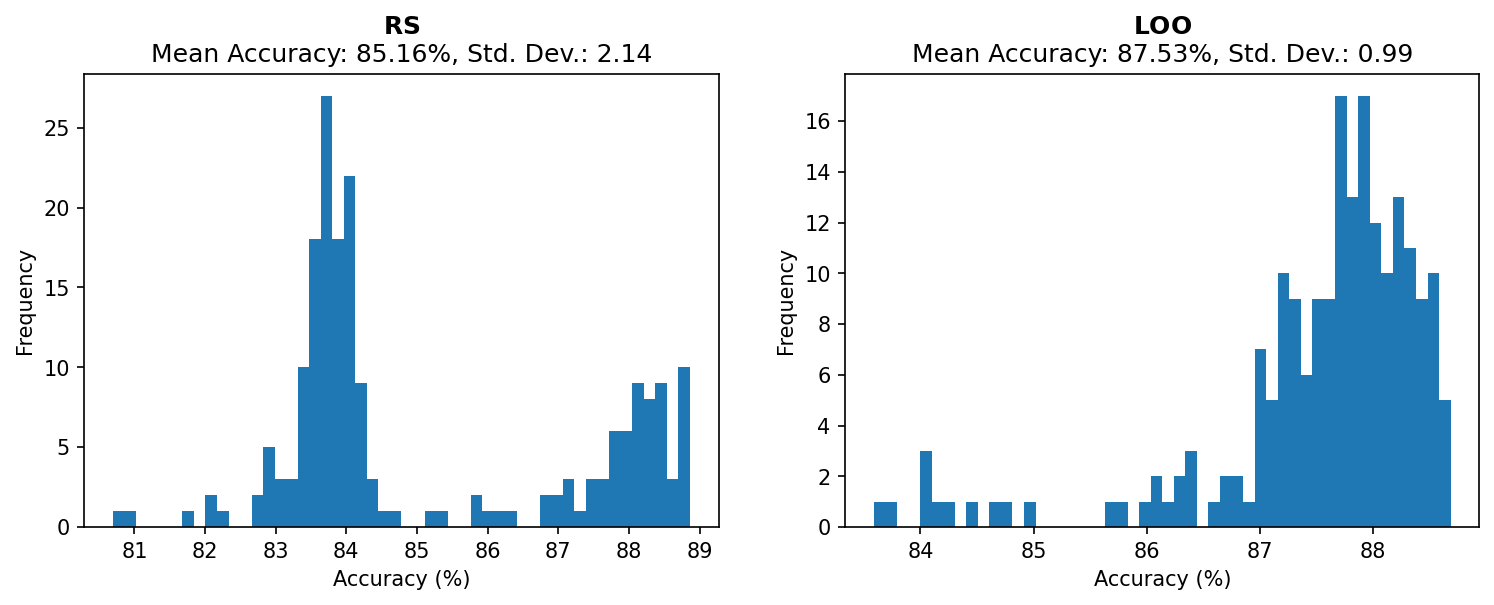

In [5]:
accs = []  # append 2 numpy arrays of size 200
for i, random_source in enumerate(random_sources):
    accs.append(compute_accuracies(preds[i], y_test))
plot_accuracies(accs, random_sources)

In [6]:
print_table_1(accs, random_sources)


Randomness		FMNIST
----------------------------------------
RS			85.16±2.14
----------------------------------------
LOO			87.53±0.99
----------------------------------------

Table 1: Mean accuracy over 200 models
trained over changes to random initialization
and leave-one-out differences in training data.


### Table 2: Proportion of points with disagreement

##### Compare Singleton Models

In [7]:
# For one input, if any two predictions differ (across all models), disagreement = 1
# Computes proportion of inputs with disagreement = 1
# pred is size (no. models x no.inputs)
disagreements_full = [compute_disagreement(pred) for pred in preds]

##### Construct and Compare Selective Ensembles

In [8]:
n_ensembles_per_comparison = 10  # number of ensembles to compare
ensemble_sizes = [5, 10, 15, 20]  # number of models per ensemble

# Disagreement between set of fixed-size selective ensembles
selective_disagreements = np.zeros((len(random_sources), len(ensemble_sizes)))

# Disagreement between set of fixed-size traditional (majority vote) ensembles
traditional_disagreements = np.zeros((len(random_sources), len(ensemble_sizes)))

In [9]:
# Compute these statistics for Table 3 (next section)
shape = [len(random_sources), len(ensemble_sizes), n_ensembles_per_comparison]
selective_accs = np.zeros(shape)  # accuracies of selective ensembles
abstention_rates = np.zeros(shape)  # abstention rates of selective ensembles
traditional_accs = np.zeros(shape)  # accuracies of traditional ensembles

In [10]:
# For each source of randomness
for i, random_source in enumerate(random_sources):
    print(bold(f'\nSource of Randomness: {random_source.upper()}'))

    # For each different ensemble size (5, 10, 15, 20)
    print("Constructing and comparing sets of 10 ensembles for ensemble sizes (5, 10, 15, 20)...")
    for j, ensemble_size in enumerate(tqdm(ensemble_sizes)):

        # Size of preds is no. ensembles x no. inputs
        args = [ensemble_size, n_ensembles_per_comparison, preds[i], 'selective']
        selective_ensemble_preds = compute_ensemble_predictions(*args)

        # Accuracy and abstention
        selective_accs[i,j] = compute_accuracies(selective_ensemble_preds, y_test)
        abstention_rates[i,j] = compute_abstention_rate(selective_ensemble_preds)
        
        # Traditional majority voting
        args = [ensemble_size, n_ensembles_per_comparison, preds[i], 'majority']
        traditional_ensemble_preds = compute_ensemble_predictions(*args)
        traditional_accs[i,j] = compute_accuracies(traditional_ensemble_preds, y_test)
        
        # Disagreement between selective ensembles (scalar)
        selective_disagreements[i,j] = compute_disagreement(selective_ensemble_preds)
        
        # Disagreement between traditional ensembles (scalar)
        traditional_disagreements[i,j] = compute_disagreement(traditional_ensemble_preds)


Source of Randomness: RS
Constructing and comparing sets of 10 ensembles for ensemble sizes (5, 10, 15, 20)...


100%|██████████| 4/4 [00:16<00:00,  4.03s/it]



Source of Randomness: LOO
Constructing and comparing sets of 10 ensembles for ensemble sizes (5, 10, 15, 20)...


100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


##### Not included in the paper

Since we compare sets of 10 ensembles, it seems more fair <br />
to compare sets of 10 singleton models sampled from the set of 200, <br />
rather than computing disagreement between 200 models, since <br />
chance of disagreement *increases* as you add more singletons to the set <br />

i.e. if you train thousands of models, you only require 1 different prediction <br />
for an input before disagreement is permanently 1 for that input

In [31]:
# Repeat singleton model comparison but over 20 trials of 10 models
trials = n_models//n_ensembles_per_comparison
disagreements_partial = np.zeros((len(random_sources), trials))
for i in range(len(random_sources)):
    for j in range(trials):
        lower = j*n_ensembles_per_comparison
        upper = (j+1)*n_ensembles_per_comparison
        disagreements_partial[i,j] = compute_disagreement(preds[i][lower:upper])

##### Print Table 2 (FMNIST)

In [32]:
print_table_2(disagreements_full, disagreements_partial,
              selective_disagreements, ensemble_sizes, random_sources)


Randomness		n			FMNIST
------------------------------------------------------------
RS			1 (full)		0.4564
RS			1 (partial)		0.2368
RS			5			0.2784
RS			10			0.1799
RS			15			0.1506
RS			20			0.1413
------------------------------------------------------------
LOO			1 (full)		0.3982
LOO			1 (partial)		0.2146
LOO			5			0.2771
LOO			10			0.1625
LOO			15			0.1364
LOO			20			0.1124
------------------------------------------------------------

Table 2: Proportion of points with disagreement
between at least one pair of models (p_flip>0)
trained with different random seeds (RS) or leave-
one-out (LOO) differences in training data for
singleton models (n=1) and selective ensembles (n>1).
All 200 models are used in the (full) comparison, while
10 models or ensembles are used in the remaining rows.


### Table 3: Selective vs Traditional Ensemble Comparison

In [40]:
print_table_3(selective_accs, abstention_rates,
              traditional_accs, ensemble_sizes, random_sources)


Key: accuracy (abstain as error) | abstention rate | non-selective accuracy

Randomness		n		    FMNIST
------------------------------------------------------------
RS			5		76.1|19.7|86.9
RS			10		81.4|10.4|86.5
RS			15		82.1|9.41|85.8
RS			20		82.6|7.73|85.8
------------------------------------------------------------
LOO			5		79.5|15.8|88.8
LOO			10		84.6|8.60|89.0
LOO			15		85.4|7.32|89.2
LOO			20		86.1|6.28|89.2
------------------------------------------------------------

Table 3: Accuracy and abstention rate of selective ensembles,
along with the accuracy of non-selective (traditional ensembles)
with n ∈ {5,10,15,20} constituents. Results are averaged over 10
randomly selected models.


### Figure 3a: Selective vs Traditional Ensemble Disagreement

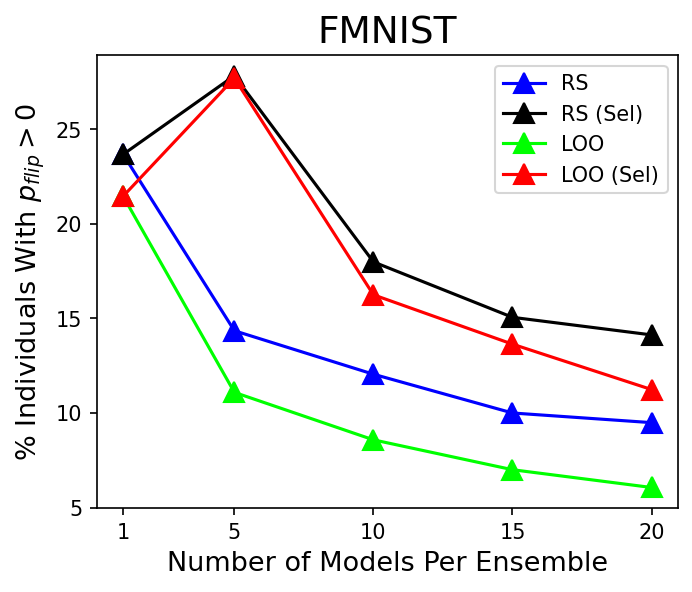


Figure 3a: Percentage of test data with non-zero disagreement
rate in traditional (i.e., majority vote but not selective
ensembles. Horizontal axis depicts ensemble size.

The paper claims that "while ensembling alone mitigates
much of the prediction instability, it is unable to eliminate
it as selective ensembles do". We discuss our opposing findings.


In [42]:
plot_figure_3a(disagreements_partial, traditional_disagreements,
               selective_disagreements, ensemble_sizes, random_sources)